In [1]:
import numpy as np
import pandas as pd
import cv2
import functools

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split

from model_testing import ModelSelection
from plotting import show_distribution
from plot_val import calc_roc_curve, plot_roc_curve, plot_confusion_matrix

from apply_processing import apply, resize_images, function_hls, function_gray
from apply_processing import function_label, blur_images, adjust_contrast_images, rotated_labels
from apply_processing import filter_images, edge_images, contour_images, rotate_images

In [2]:
df = pd.read_csv("Dataset\\images_mushrooms.csv")

df.head()

,Image,Label
0,Dataset\Mushrooms\Agaricus\009_mrv34Sn4WiQ.jpg,Agaricus
1,Dataset\Mushrooms\Agaricus\010_Rk1D3EG856g.jpg,Agaricus
2,Dataset\Mushrooms\Agaricus\017_QHGfbEiWvq8.jpg,Agaricus
3,Dataset\Mushrooms\Agaricus\020_vZJfrjIwmqU.jpg,Agaricus
4,Dataset\Mushrooms\Agaricus\030_-i6kYqDvBQo.jpg,Agaricus


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   900 non-null    object
 1   Label   900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


In [4]:
df['Label'].value_counts()

Suillus        100
Russula        100
Amanita        100
Hygrocybe      100
Boletus        100
Agaricus       100
Cortinarius    100
Lactarius      100
Entoloma       100
Name: Label, dtype: int64

# Processing the images

## No Augmentation

In [5]:
# Fixed contrast, brightness, sharpness

def processing_noAug(df):
    images = df['Image']
    labels = df["Label"]
    
    size = (150, 150)
    
    mod_images = function_hls(images)
    mod_images = resize_images(mod_images, size)
    mod_images = filter_images(mod_images)
    mod_images = adjust_contrast_images(mod_images, contrast=1.75, brightness=10)
    mod_images = blur_images(mod_images)
    
    return mod_images, labels

images_noAug, labels_noAug = processing_noAug(df)

## Augmentation function

In [6]:
# With Contour + Fixed contrast, brightness, sharpness

def processing_contour(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.75
    brightness = 10
    
    images_hls = function_hls(images)
    images_hls = resize_images(images_hls, size)
    images_hls = filter_images(images_hls)
    images_hls = adjust_contrast_images(images_hls, contrast=contrast, brightness=brightness)
    images_hls = blur_images(images_hls)
    
    images_gray = function_gray(images)
    images_gray = resize_images(images_gray, size)
    images_gray = filter_images(images_gray)
    images_gray = adjust_contrast_images(images_gray, contrast=contrast, brightness=brightness)
    images_gray = blur_images(images_gray)
    
    edged_images = edge_images(images_gray)
    
    images_contour = contour_images(edged_images, images_hls)
    
    return list(images_contour)

In [7]:
# Random Contrast, Brightness, Sharpness

def processing_random(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = np.random.randint(1, 5)
    brightness = np.random.randint(-100, 100)
    
    images_hls = function_hls(images)
    images_hls = resize_images(images_hls, size)
    images_hls = filter_images(images_hls)
    images_hls = adjust_contrast_images(images_hls, contrast=contrast, brightness=brightness)
    images_hls = blur_images(images_hls)
    
    return list(images_hls)

In [8]:
# Fixed contrast, brightness, sharpness

def processing_fixed(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.75
    brightness = 10
    
    images_hls = function_hls(images)
    images_hls = resize_images(images_hls, size)
    images_hls = filter_images(images_hls)
    images_hls = adjust_contrast_images(images_hls, contrast=contrast, brightness=brightness)
    images_hls = blur_images(images_hls)
    
    return list(images_hls)

In [9]:
# Rotated and flipped images

def processing_rotated(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.75
    brightness = 10
    
    images_hls = function_hls(images)
    images_hls = resize_images(images_hls, size)
    images_hls = filter_images(images_hls)
    images_hls = adjust_contrast_images(images_hls, contrast=contrast, brightness=brightness)
    images_hls = blur_images(images_hls)
    images_hls = rotate_images(images_hls)
    
    return list(images_hls)

In [10]:
functions = [processing_contour, processing_random, processing_fixed]
labels = [function_label, function_label, function_label]

images_aug, labels_aug = apply(functions, labels, df)

# Images info

In [11]:
print(f"Length of images no augmentation {len(images_noAug)}")
print(f"Length of images with augmentation {len(images_aug)}")

Length of images no augmentation 900
Length of images with augmentation 2700


## Images info no augmentation

In [12]:
# show_distribution(images_noAug)

## Images info augmentation

In [13]:
# show_distribution(images_aug)

# Modelling with no augmentation

## Reduction with PCA

In [14]:
scaler = MinMaxScaler()
le = LabelEncoder()

pca = PCA(n_components=100)

In [15]:
images = [np.ravel(image) for image in images_noAug]

images_scaled = scaler.fit_transform(images)
labels_encoded = le.fit_transform(df["Label"])

In [16]:
images_pca = pca.fit_transform(images_scaled, labels_encoded)

images_pca_df = pd.DataFrame(data=images_pca)
images_pca_df["Label"] = le.inverse_transform(labels_encoded)

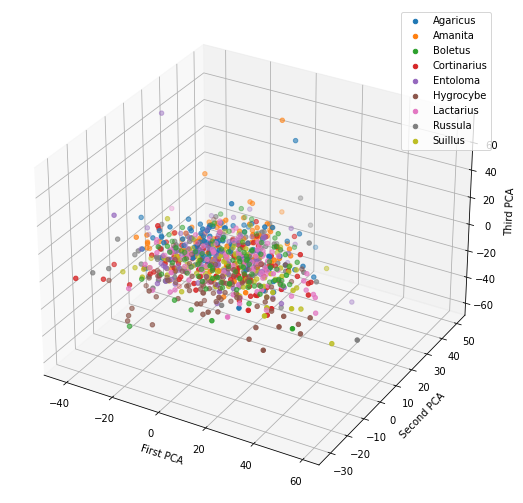

In [17]:
fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(projection='3d')

for label in images_pca_df["Label"].unique():
    first_pca = images_pca_df[images_pca_df["Label"] == label][0]
    second_pca = images_pca_df[images_pca_df["Label"] == label][1]
    third_pca = images_pca_df[images_pca_df["Label"] == label][2]
    
    ax.scatter(first_pca, second_pca, third_pca, label=label)
    
ax.legend()

ax.set_xlabel("First PCA")
ax.set_ylabel("Second PCA")
ax.set_zlabel("Third PCA")

plt.show()

## Modelling

In [18]:
X = images_pca_df.drop(columns=["Label"])
y = pd.Series(le.fit_transform(images_pca_df["Label"]))

### Using train_test_split

In [19]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [20]:
selection.use_train_test_split()

Model info
--------------------
Model name : RandomForestClassifier
Model name : DecisionTreeClassifier
Model name : MLPClassifier
Model name : SVC

Training models
--------------------
Done Training RandomForestClassifier in time:0.6681039333343506
Done Training DecisionTreeClassifier in time:0.7149770259857178
Done Training MLPClassifier in time:2.2548696994781494
Done Training SVC in time:2.4419541358947754
--------------------
Done Training models in time : 2.4419541358947754


The Scores :

Train RandomForestClassifier score : 1.0
Train DecisionTreeClassifier score : 1.0
Train MLPClassifier score : 0.9966832504145937
Train SVC score : 0.8606965174129353
----------
Test RandomForestClassifier score : 0.27946127946127947
Test DecisionTreeClassifier score : 0.18181818181818182
Test MLPClassifier score : 0.21885521885521886
Test SVC score : 0.31313131313131315
----------
Bias RandomForestClassifier score : 0.7205387205387206
Bias DecisionTreeClassifier score : 0.8181818181818181
Bias 

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Using StratifiedKFold

In [21]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [22]:
selection.use_stratifiedkfold()

Fold 1
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.7085378170013428

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.25555555555555554
Bias RandomForestClassifier score : 0.7444444444444445

--------------------
Done Training DecisionTreeClassifier in time:0.7795259952545166

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.16666666666666666
Bias DecisionTreeClassifier score : 0.8333333333333334


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.4496243000030518

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.2611111111111111
Bias MLPClassifier score : 0.7388888888888889

--------------------
Done Training SVC in time:2.69954776763916

The Scores :

Train SVC score : 0.8375
Test SVC score : 0.3055555555555556
Bias SVC score : 0.5319444444444444
--------------------
Done Training models in time : 2.69954776763916

Fold 2
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.6869096755981445

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.2222222222222222
Bias RandomForestClassifier score : 0.7777777777777778

--------------------
Done Training DecisionTreeClassifier in time:0.7519466876983643

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.17777777777777778
Bias DecisionTreeClassifier score : 0.82222222222222

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.425856590270996

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.2777777777777778
Bias MLPClassifier score : 0.7222222222222222

--------------------
Done Training SVC in time:2.682539224624634

The Scores :

Train SVC score : 0.8263888888888888
Test SVC score : 0.28888888888888886
Bias SVC score : 0.5375
--------------------
Done Training models in time : 2.682539224624634

Fold 3
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.6848094463348389

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.2833333333333333
Bias RandomForestClassifier score : 0.7166666666666667

--------------------
Done Training DecisionTreeClassifier in time:0.7557213306427002

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.2
Bias DecisionTreeClassifier score : 0.8


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.423794984817505

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.2777777777777778
Bias MLPClassifier score : 0.7222222222222222

--------------------
Done Training SVC in time:2.660720109939575

The Scores :

Train SVC score : 0.8486111111111111
Test SVC score : 0.3055555555555556
Bias SVC score : 0.5430555555555555
--------------------
Done Training models in time : 2.660720109939575

Fold 4
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.6834473609924316

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.28888888888888886
Bias RandomForestClassifier score : 0.7111111111111111

--------------------
Done Training DecisionTreeClassifier in time:0.7524154186248779

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.17777777777777778
Bias DecisionTreeClassifier score : 0.

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.423903226852417

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.2111111111111111
Bias MLPClassifier score : 0.7888888888888889

--------------------
Done Training SVC in time:2.6637117862701416

The Scores :

Train SVC score : 0.8638888888888889
Test SVC score : 0.3388888888888889
Bias SVC score : 0.525
--------------------
Done Training models in time : 2.6637117862701416

Fold 5
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.6776907444000244

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.25
Bias RandomForestClassifier score : 0.75

--------------------
Done Training DecisionTreeClassifier in time:0.7486777305603027

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.15
Bias DecisionTreeClassifier score : 0.85


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.4004549980163574

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.22777777777777777
Bias MLPClassifier score : 0.7722222222222223

--------------------
Done Training SVC in time:2.636709213256836

The Scores :

Train SVC score : 0.8458333333333333
Test SVC score : 0.2611111111111111
Bias SVC score : 0.5847222222222221
--------------------
Done Training models in time : 2.6377081871032715


The Mean Scores :

Train mean RandomForestClassifier score : 1.0
Train mean DecisionTreeClassifier score : 1.0
Train mean MLPClassifier score : 1.0
Train mean SVC score : 0.8458333333333333
----------
Test mean RandomForestClassifier score : 0.25
Test mean DecisionTreeClassifier score : 0.15
Test mean MLPClassifier score : 0.22777777777777777
Test mean SVC score : 0.2611111111111111
----------
Bias mean RandomForestClassifier score : 0.75
Bias mean DecisionTreeClassifier score : 0.85
Bias mean MLPClassifier score :

## Evaluation

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
svm = SVC(probability=True)
dtc = DecisionTreeClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()

In [25]:
svm.fit(X_train, y_train)
dtc.fit(X_train, y_train)
mlpc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomForestClassifier()

### ROC Curve and AUC

In [26]:
svm_proba = svm.predict_proba(X_test)
dtc_proba = dtc.predict_proba(X_test)
mlpc_proba = mlpc.predict_proba(X_test)
rfc_proba = rfc.predict_proba(X_test)

In [27]:
fprs_svm, tprs_svm, aucs_svm = calc_roc_curve(y_test, svm_proba)
fprs_dtc, tprs_dtc, aucs_dtc = calc_roc_curve(y_test, dtc_proba)
fprs_mlpc, tprs_mlpc, aucs_mlpc = calc_roc_curve(y_test, mlpc_proba)
fprs_rfc, tprs_rfc, aucs_rfc = calc_roc_curve(y_test, rfc_proba)

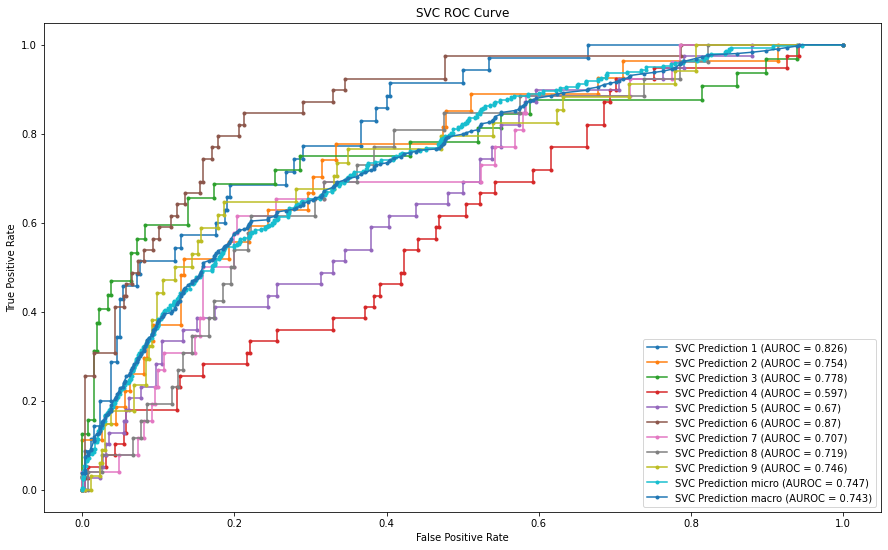

In [28]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_svm, tprs_svm, aucs_svm, "SVC")

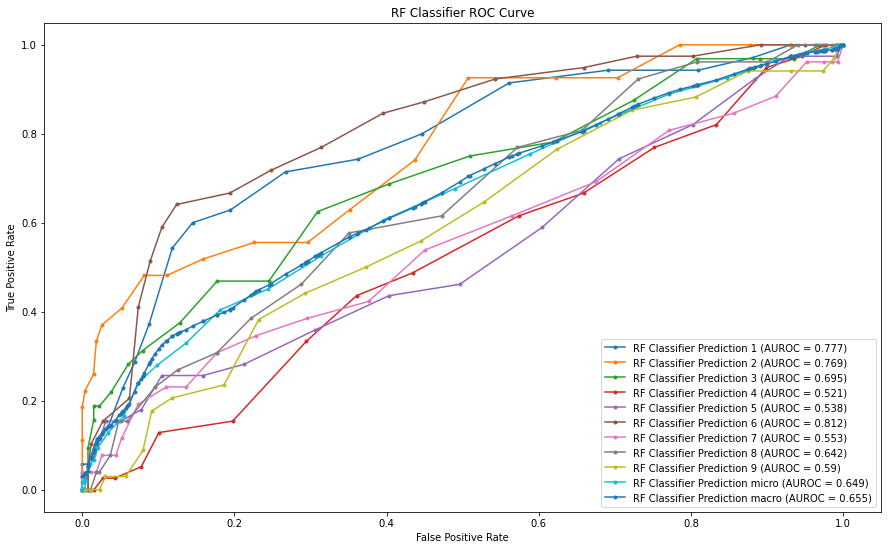

In [29]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_rfc, tprs_rfc, aucs_rfc, "RF Classifier")

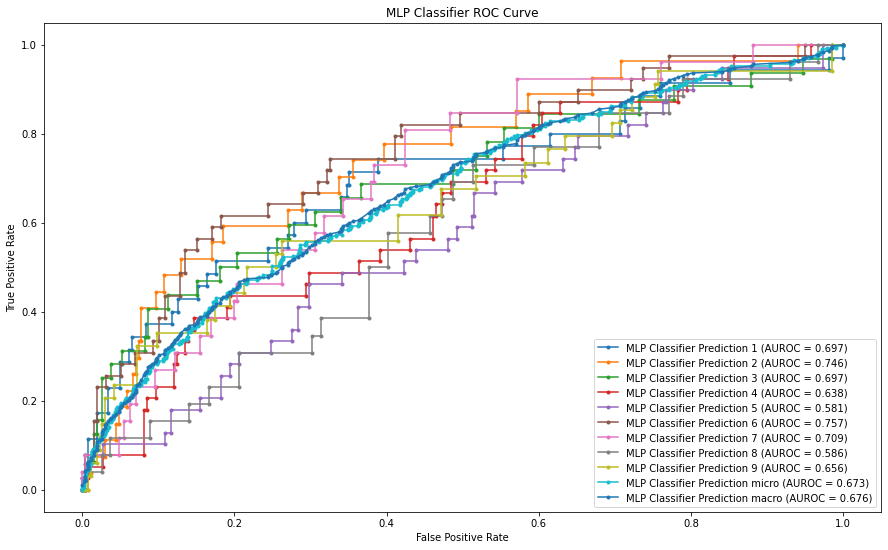

In [30]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_mlpc, tprs_mlpc, aucs_mlpc, "MLP Classifier")

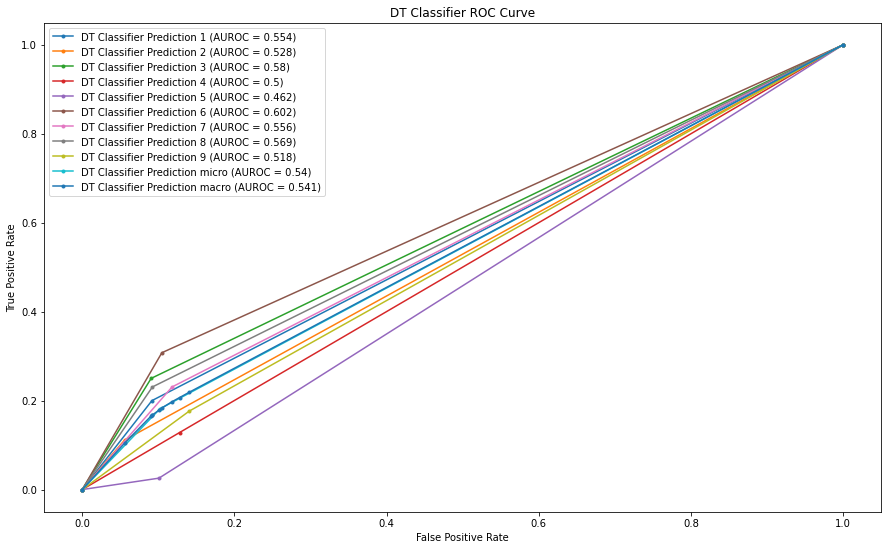

In [31]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_dtc, tprs_dtc, aucs_dtc, "DT Classifier")

### Confusion Matrix

In [32]:
svm_pred = svm.predict(X_test)
dtc_pred = dtc.predict(X_test)
mlpc_pred = mlpc.predict(X_test)
rfc_pred = rfc.predict(X_test)

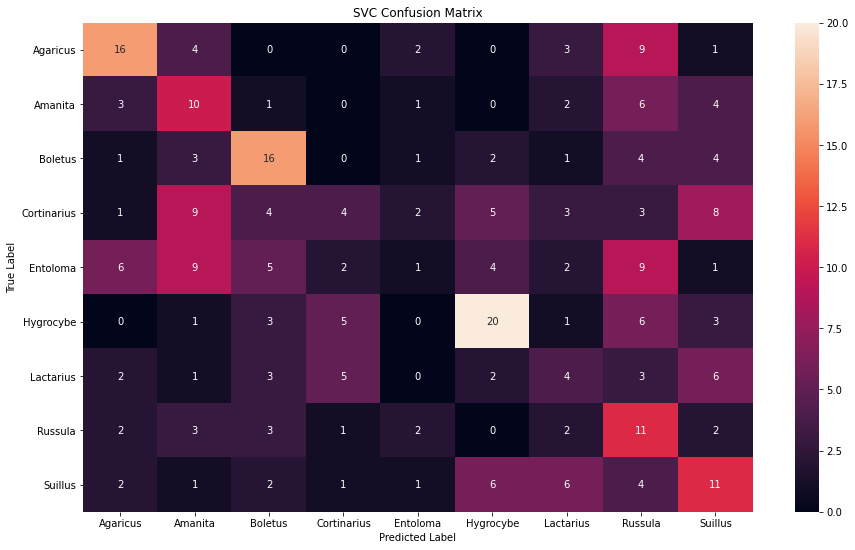

In [33]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, svm_pred, 'SVC')

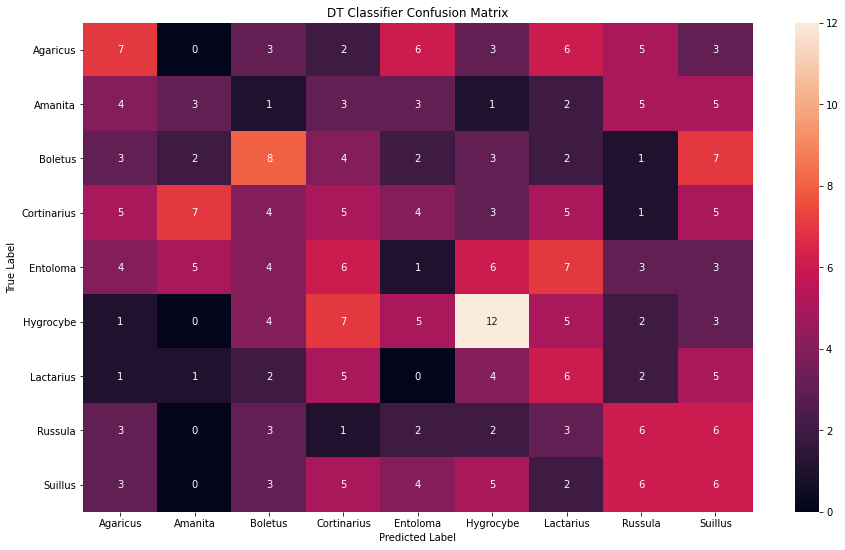

In [34]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, dtc_pred, 'DT Classifier')

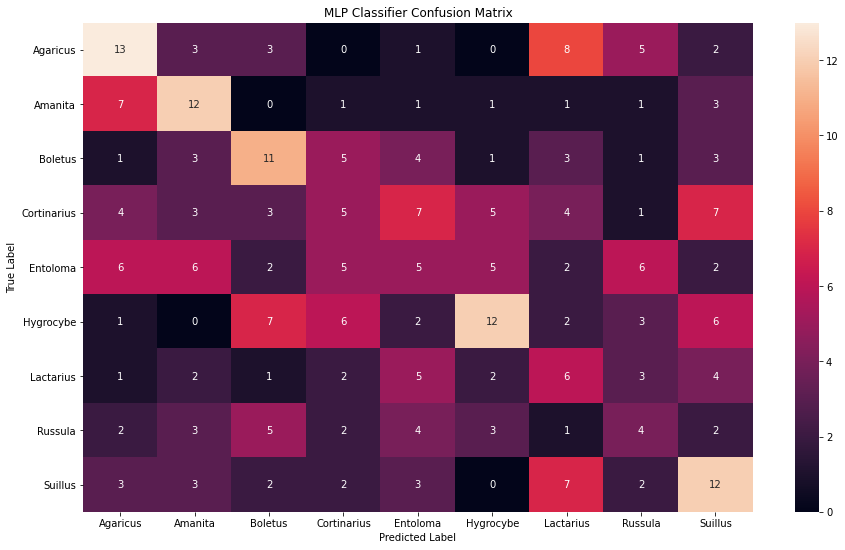

In [35]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, mlpc_pred, 'MLP Classifier')

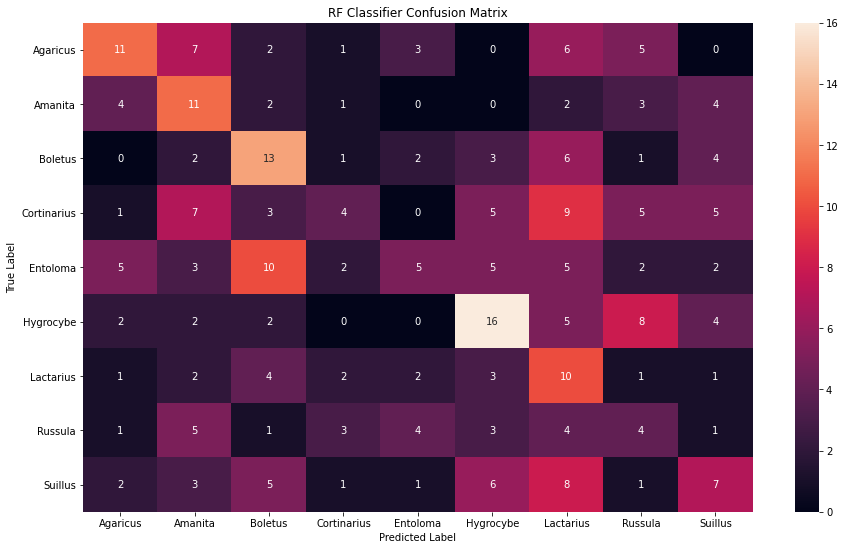

In [36]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, rfc_pred, 'RF Classifier')

# Modelling with augmentation

## Reduction with PCA

In [37]:
scaler = MinMaxScaler()
le = LabelEncoder()

pca = PCA(n_components=100)

In [38]:
images = [np.ravel(image) for image in images_aug]

images_scaled = scaler.fit_transform(images)
labels_encoded = le.fit_transform(labels_aug)

In [39]:
images_pca = pca.fit_transform(images_scaled, labels_encoded)

images_pca_df = pd.DataFrame(data=images_pca)
images_pca_df["Label"] = le.inverse_transform(labels_encoded)

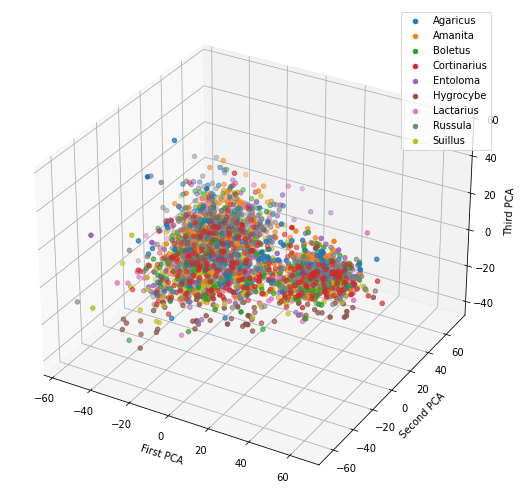

In [40]:
fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(projection='3d')

for label in images_pca_df["Label"].unique():
    first_pca = images_pca_df[images_pca_df["Label"] == label][0]
    second_pca = images_pca_df[images_pca_df["Label"] == label][1]
    third_pca = images_pca_df[images_pca_df["Label"] == label][2]
    
    ax.scatter(first_pca, second_pca, third_pca, label=label)
    
ax.legend()

ax.set_xlabel("First PCA")
ax.set_ylabel("Second PCA")
ax.set_zlabel("Third PCA")

plt.show()

## Modelling

In [41]:
X = images_pca_df.drop(columns=["Label"])
y = pd.Series(le.fit_transform(images_pca_df["Label"]))

### Using train_test_split

In [42]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [43]:
selection.use_train_test_split()

Model info
--------------------
Model name : RandomForestClassifier
Model name : DecisionTreeClassifier
Model name : MLPClassifier
Model name : SVC

Training models
--------------------
Done Training RandomForestClassifier in time:2.369917154312134
Done Training DecisionTreeClassifier in time:2.621678590774536


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Done Training MLPClassifier in time:7.1299238204956055
Done Training SVC in time:8.93003797531128
--------------------
Done Training models in time : 8.93003797531128


The Scores :

Train RandomForestClassifier score : 1.0
Train DecisionTreeClassifier score : 1.0
Train MLPClassifier score : 1.0
Train SVC score : 0.7440574903261471
----------
Test RandomForestClassifier score : 0.8148148148148148
Test DecisionTreeClassifier score : 0.372615039281706
Test MLPClassifier score : 0.5375982042648709
Test SVC score : 0.3838383838383838
----------
Bias RandomForestClassifier score : 0.18518518518518523
Bias DecisionTreeClassifier score : 0.627384960718294
Bias MLPClassifier score : 0.4624017957351291
Bias SVC score : 0.3602191064877633
----------


### Using StratifiedKFold

In [44]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [45]:
selection.use_stratifiedkfold()

Fold 1
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.3184115886688232

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.8925925925925926
Bias RandomForestClassifier score : 0.1074074074074074

--------------------
Done Training DecisionTreeClassifier in time:2.588557720184326

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.4648148148148148
Bias DecisionTreeClassifier score : 0.5351851851851852


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:7.7660088539123535

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.6981481481481482
Bias MLPClassifier score : 0.3018518518518518

--------------------
Done Training SVC in time:9.825594663619995

The Scores :

Train SVC score : 0.7287037037037037
Test SVC score : 0.44074074074074077
Bias SVC score : 0.287962962962963
--------------------
Done Training models in time : 9.825594663619995

Fold 2
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.2064430713653564

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.9185185185185185
Bias RandomForestClassifier score : 0.08148148148148149

--------------------
Done Training DecisionTreeClassifier in time:2.4772446155548096

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.4166666666666667
Bias DecisionTreeClassifier score : 0.

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:8.551216840744019

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.6796296296296296
Bias MLPClassifier score : 0.3203703703703704

--------------------
Done Training SVC in time:11.072278499603271

The Scores :

Train SVC score : 0.7393518518518518
Test SVC score : 0.43148148148148147
Bias SVC score : 0.30787037037037035
--------------------
Done Training models in time : 11.072278499603271

Fold 3
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.007737398147583

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.9
Bias RandomForestClassifier score : 0.09999999999999998

--------------------
Done Training DecisionTreeClassifier in time:2.2871439456939697

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.45555555555555555
Bias DecisionTreeClassifier score : 0.544444444444

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:7.394839525222778

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.7203703703703703
Bias MLPClassifier score : 0.2796296296296297

--------------------
Done Training SVC in time:9.450717210769653

The Scores :

Train SVC score : 0.7388888888888889
Test SVC score : 0.412962962962963
Bias SVC score : 0.32592592592592595
--------------------
Done Training models in time : 9.450717210769653

Fold 4
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.0873262882232666

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.9166666666666666
Bias RandomForestClassifier score : 0.08333333333333337

--------------------
Done Training DecisionTreeClassifier in time:2.358487367630005

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.43148148148148147
Bias DecisionTreeClassifier score : 0.5

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:7.443267107009888

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.7222222222222222
Bias MLPClassifier score : 0.2777777777777778

--------------------
Done Training SVC in time:9.452976942062378

The Scores :

Train SVC score : 0.7402777777777778
Test SVC score : 0.4222222222222222
Bias SVC score : 0.3180555555555556
--------------------
Done Training models in time : 9.452976942062378

Fold 5
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.015212059020996

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.912962962962963
Bias RandomForestClassifier score : 0.08703703703703702

--------------------
Done Training DecisionTreeClassifier in time:2.2730712890625

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.45740740740740743
Bias DecisionTreeClassifier score : 0.54259

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:7.663779258728027

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.7111111111111111
Bias MLPClassifier score : 0.28888888888888886

--------------------
Done Training SVC in time:9.700079679489136

The Scores :

Train SVC score : 0.7388888888888889
Test SVC score : 0.42777777777777776
Bias SVC score : 0.31111111111111117
--------------------
Done Training models in time : 9.700079679489136


The Mean Scores :

Train mean RandomForestClassifier score : 1.0
Train mean DecisionTreeClassifier score : 1.0
Train mean MLPClassifier score : 1.0
Train mean SVC score : 0.7388888888888889
----------
Test mean RandomForestClassifier score : 0.912962962962963
Test mean DecisionTreeClassifier score : 0.45740740740740743
Test mean MLPClassifier score : 0.7111111111111111
Test mean SVC score : 0.42777777777777776
----------
Bias mean RandomForestClassifier score : 0.08703703703703702
Bias mean DecisionTreeClassifier s

## Evaluation

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
svm = SVC(probability=True)
dtc = DecisionTreeClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()

In [48]:
svm.fit(X_train, y_train)
dtc.fit(X_train, y_train)
mlpc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomForestClassifier()

### ROC Curve and AUC

In [49]:
svm_proba = svm.predict_proba(X_test)
dtc_proba = dtc.predict_proba(X_test)
mlpc_proba = mlpc.predict_proba(X_test)
rfc_proba = rfc.predict_proba(X_test)

In [50]:
fprs_svm, tprs_svm, aucs_svm = calc_roc_curve(y_test, svm_proba)
fprs_dtc, tprs_dtc, aucs_dtc = calc_roc_curve(y_test, dtc_proba)
fprs_mlpc, tprs_mlpc, aucs_mlpc = calc_roc_curve(y_test, mlpc_proba)
fprs_rfc, tprs_rfc, aucs_rfc = calc_roc_curve(y_test, rfc_proba)

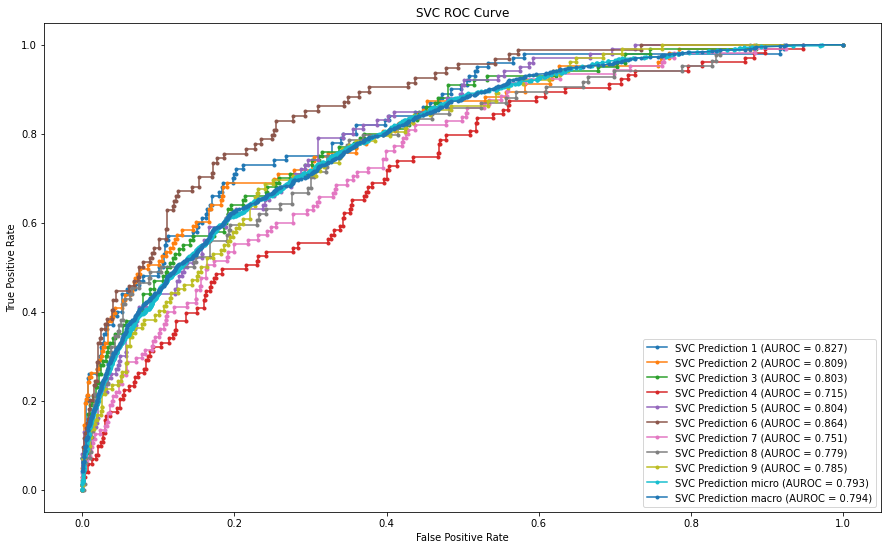

In [51]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_svm, tprs_svm, aucs_svm, "SVC")

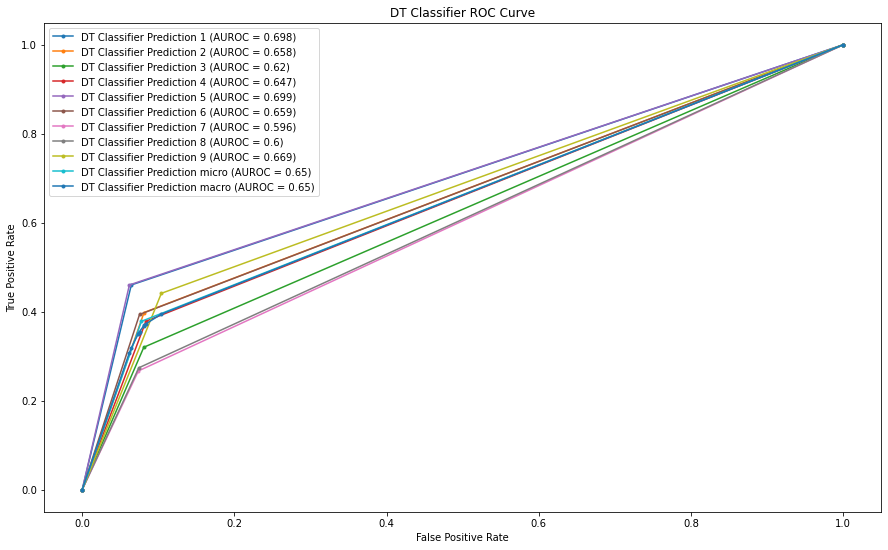

In [52]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_dtc, tprs_dtc, aucs_dtc, "DT Classifier")

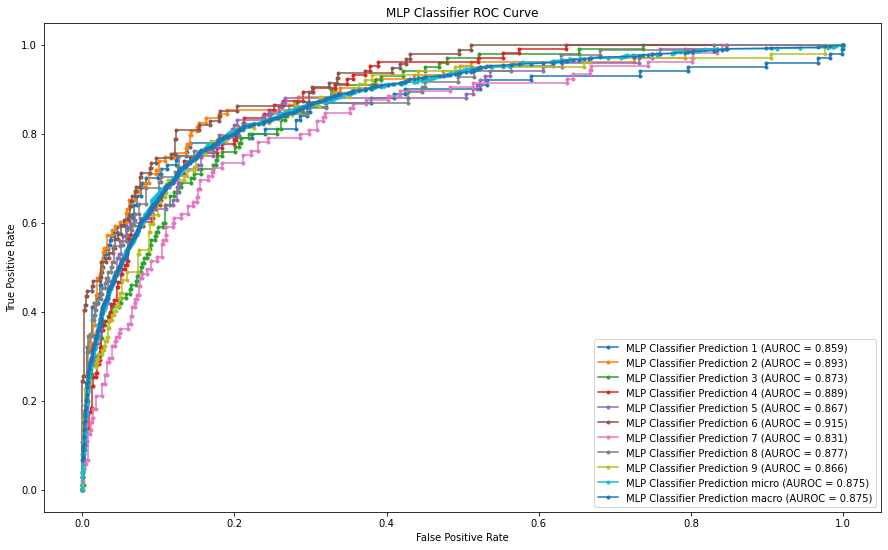

In [53]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_mlpc, tprs_mlpc, aucs_mlpc, "MLP Classifier")

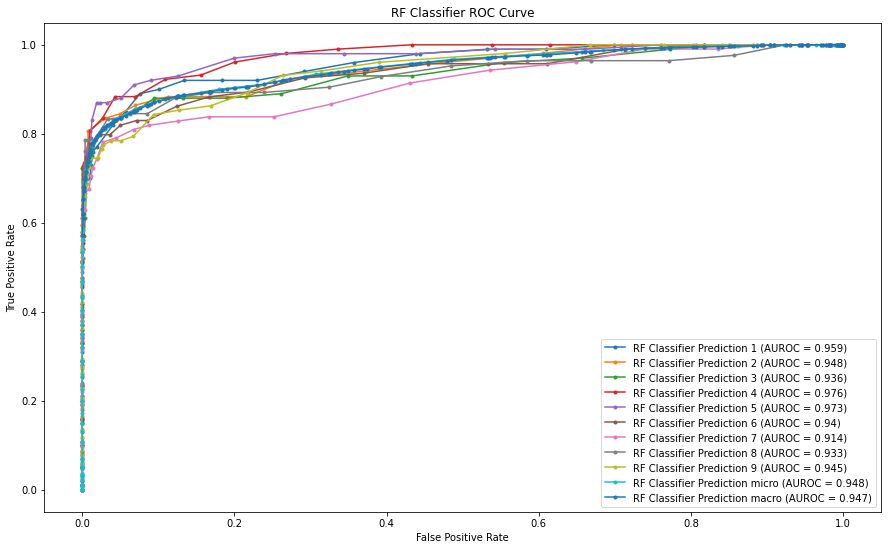

In [54]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_rfc, tprs_rfc, aucs_rfc, "RF Classifier")

### Confusion Matrix

In [55]:
svm_pred = svm.predict(X_test)
dtc_pred = dtc.predict(X_test)
mlpc_pred = mlpc.predict(X_test)
rfc_pred = rfc.predict(X_test)

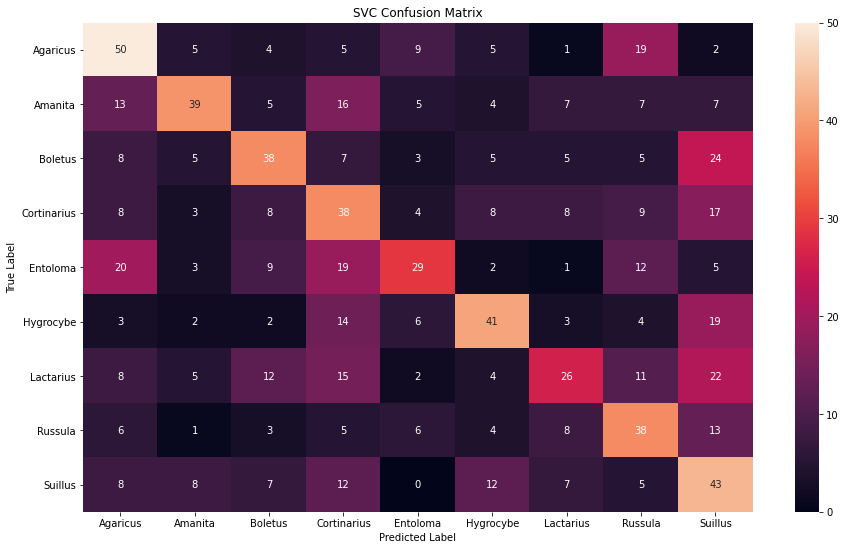

In [56]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, svm_pred, 'SVC')

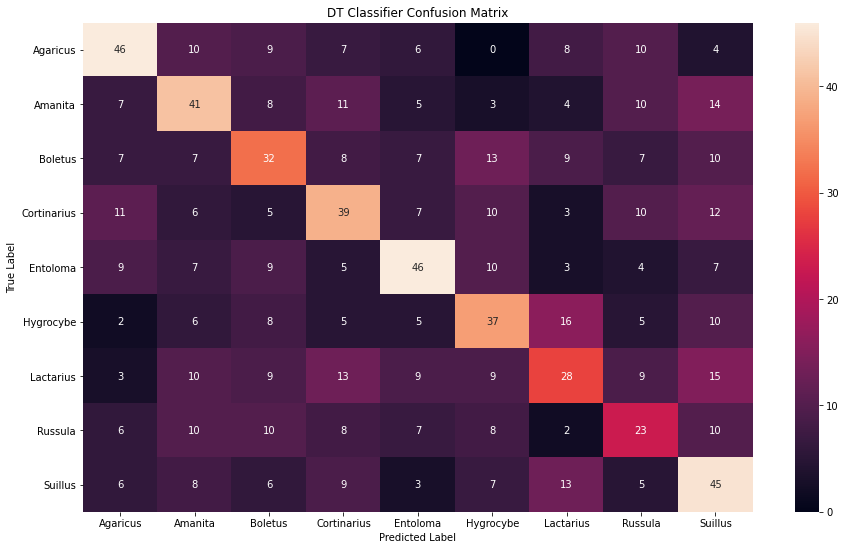

In [57]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, dtc_pred, 'DT Classifier')

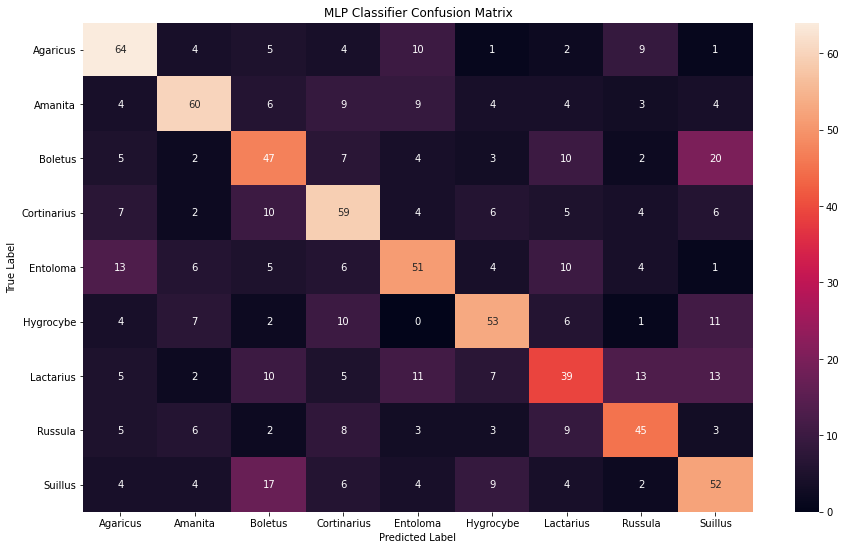

In [58]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, mlpc_pred, 'MLP Classifier')

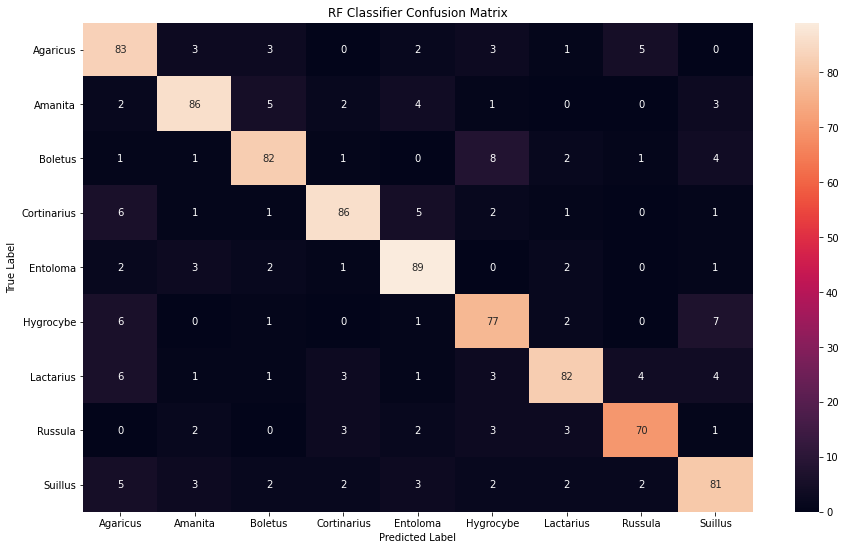

In [59]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, rfc_pred, 'RF Classifier')